In [93]:

import pandas as pd
# import inflection
import math
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.core.display import HTML
from IPython.core.display import Image
import datetime
from scipy import stats as ss

# 0.0 Imports

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y )
    cm = cm.values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2.Loading data

In [3]:
df_sales_raw = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 Descriçao dos dados

In [4]:
def jupyter_settings():    
    sns.set()
jupyter_settings()

In [5]:
# Sempre que mudar de secao da um .copy(), pois ajuda quando a gente ta navegando em um notebook mt grande
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
# cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
#        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
#        'CompetitionDistance', 'CompetitionOpenSinceMonth',
#        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
#        'Promo2SinceYear', 'PromoInterval']

# snakecase = lambda x: inflection.underscore( x )

# #fazer o mapeamento da nossa funçao snakecase em todas as minhas cols_old
# cols_new = list( map( snakecase, cols_old ) )

cols_new = [ 'store','day_of_week','date','sales','customers','open','promo','state_holiday','school_holiday','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','promo_interval' ]

# renaming
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print( 'number of Rows: {}'.format( df1.shape[0] ) )
print( 'number of Rows: {}'.format( df1.shape[1] ) )


number of Rows: 1017209
number of Rows: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance( vamos supor que ta na pq a distancia é mt grande de outra loja )
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: (df1['competition_distance'].max())*10 if math.isnan( x ) else x )


# competition_open_since_month( vamos copiar a data de venda da loja para essa coluna )
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


# competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


# promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )



# promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1['competition_distance'].max()

758600.0

In [14]:
df1.sample(5).T # transposto(inverte linha e coluna)

,955026,517882,563477,624724,527983
store,257,193,73,1110,259
day_of_week,1,1,2,4,6
date,2013-02-25 00:00:00,2014-03-24 00:00:00,2014-02-11 00:00:00,2013-12-19 00:00:00,2014-03-15 00:00:00
sales,5993,3271,4276,7502,9242
customers,754,635,539,780,1866
open,1,1,1,1,1
promo,0,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,c,b


## 1.6 Change Types
    - ( sempre que a gente faz uma alteraçao nas colunas, como foi preencher os dados faltantes, a gente tem qeu checar se esta tudo ok com os tipos )

In [15]:
print( df1.dtypes )


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


In [16]:
# df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
# df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
#
# df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
# df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency -  mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skev, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # Esse T é para uma vermos melhor o dataset
d2 = pd.DataFrame( num_attributes.apply( min ) ).T # Esse T é para uma vermos melhor o dataset
d3 = pd.DataFrame( num_attributes.apply( max ) ).T # Esse T é para uma vermos melhor o dataset
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T # Esse T é para uma vermos melhor o dataset
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # Esse T é para uma vermos melhor o dataset
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis ) ).T # Esse T é para uma vermos melhor o dataset

# concatenate
dfDesc = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d4 ] ).T.reset_index()

dfDesc.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
print(dfDesc)

                      attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  758600.0  758580.0  7386.296140   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   

C:\Users\PICHAU\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

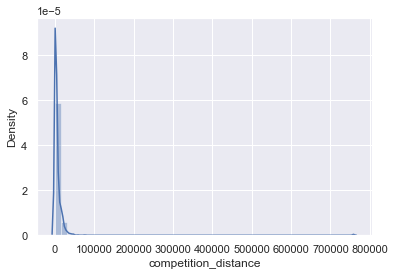

In [20]:
sns.distplot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

In [21]:
# cat_attributes.apply( lambda x: x.unique.shape[0] )

<AxesSubplot:xlabel='store_type', ylabel='sales'>

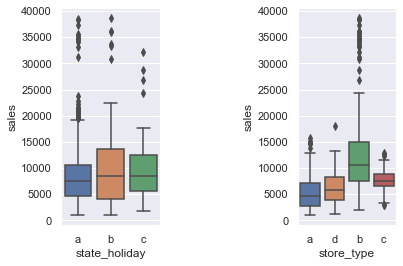

In [22]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )] # para tirar os que nao tem vendas ou nao tem estaçao

plt.subplot( 1,3,1 )
sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )

plt.subplot( 1,3,3 )
sns.boxplot( x='store_type' , y='sales' , data=aux1 )

# plt.subplot( 1,3,2 )
# sns.boxplot( x='assortment' , y='sales' , data=aux1 )

#o grafico é dividido em quartis, senod o do meio o 75  e25, a linha representa a mediana quartil 50
# video do meigarom representa mt bem o que a  gente deve olhar quando ver esse tipo de grafico
# modulo 2 , video 3

# 2.0 Feature Engineering

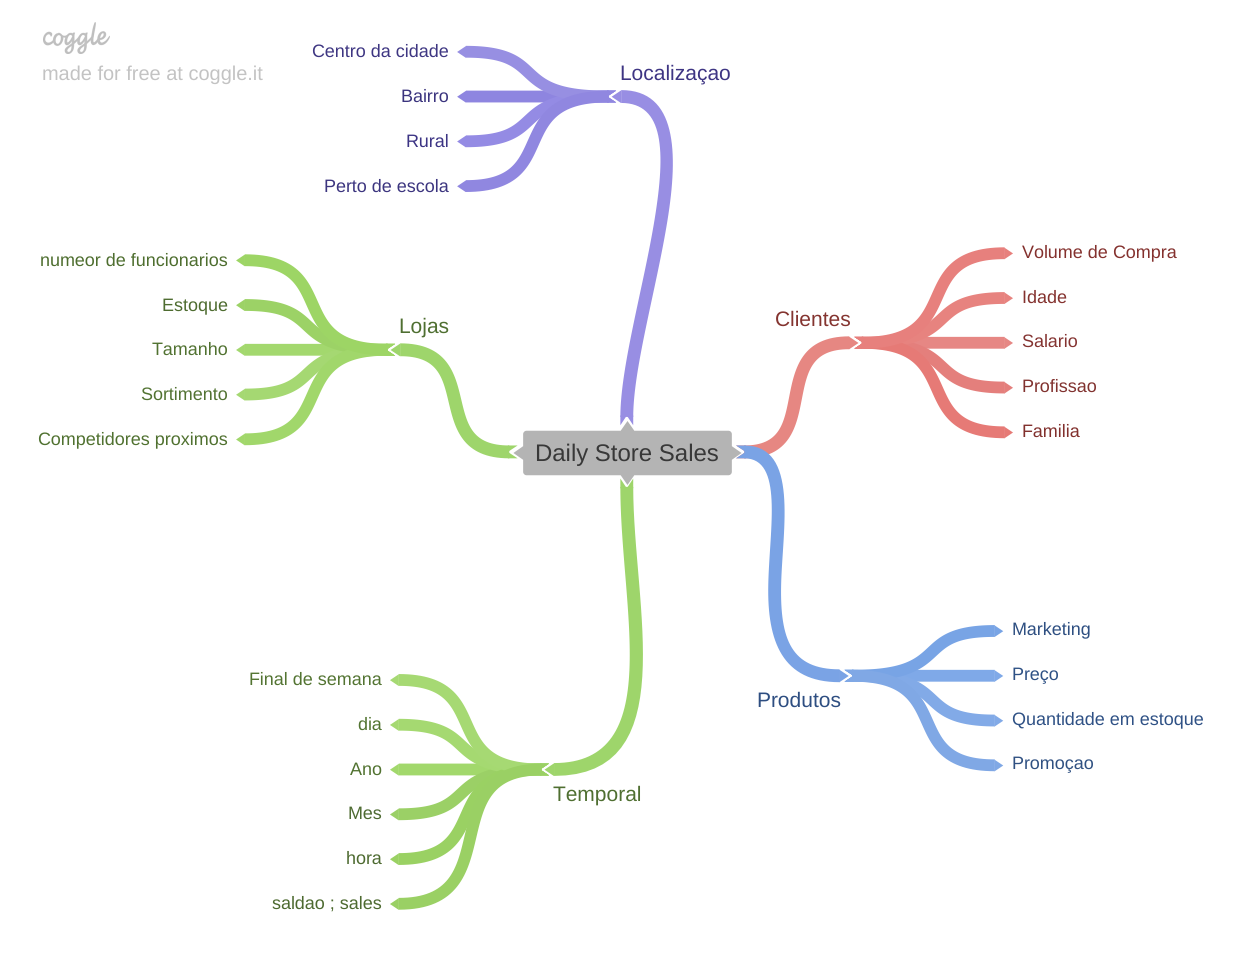

In [23]:
df2 = df1.copy()
Image( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/img/MindMapHypothesis.png' )

## 2.1 Mapa Mental de Hipoteses( Criaçao das hipoteses )


In [24]:
### 2.1.1 Hipoteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.( nao tenho numero de funcionarios nesse dataset )

**2.** Lojas com maior capacidade de estoque deveriam vender mais.( nao tenho inf do estoque )

**3.** Lojas com maior porte deveriam vender mais.( nao tenho porte da loja )

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


### 2.1.2 Hipoteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.( nao tenho despesas(budget) do marketing )

**2.** Lojas com maior exposição de produto deveriam vender mais.( nao  tenho quantidade de produtos com exposiçao )

**3.** Lojas com produtos com preço menor deveriam vender mais.( nao tenho preço dos produtos )

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.( nao temos categorias das promoçoes )

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.1.3 Hipotesese Tempo


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2 Lista Final de Hipoteses

#### Lista final Loja


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.


#### Lista final Produto


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


#### Lista final Tempo


**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.



## 2.3 Feature Engineering

In [25]:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# # competition since
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# promo since
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )



In [26]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [28]:
print(df2.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 Filtragem de variáveis

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleçao das Colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
# axis 0 => linhas
# axis 1 => colunas
df3 = df3.drop( cols_drop, axis=1 )


In [33]:
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria dos Dados

In [34]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Respose Variable

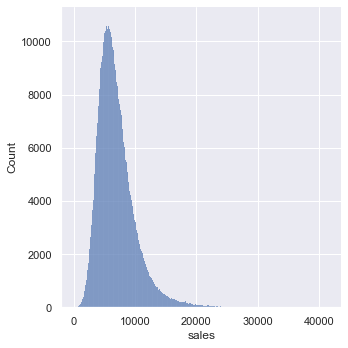

In [35]:
sns.displot( df4['sales'] )# ta pequeno os numeros no eixo y pq isso é uma plot de densidade da distribuiçao se quisermos tirar a linha que contorna é so colocar kde=False

### 4.1.2 Numerical Variable

<Figure size 3600x360 with 0 Axes>

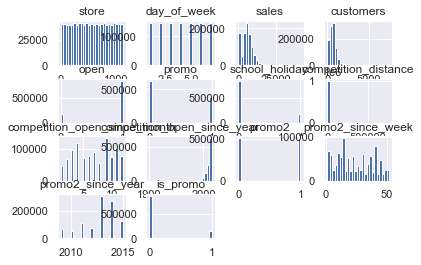

In [36]:
plt.figure( figsize=( 50, 5 ) )
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [37]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\PICHAU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PICHAU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PICHAU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

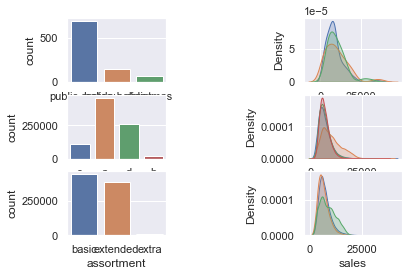

In [38]:
# state_holiday
plt.subplot( 3, 3, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 3, 3 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 3, 4 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 3, 6 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 3, 7 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 3, 9 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimentos( mix de produtos ) deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.<p>
**É importante pro modelo?** Sim, pois mesmo que o basic e o extended sejam semelhantes, o extra tem um comportamento peculiar que vale a pena treinar o modelo com ele.

<AxesSubplot:xlabel='year_week'>

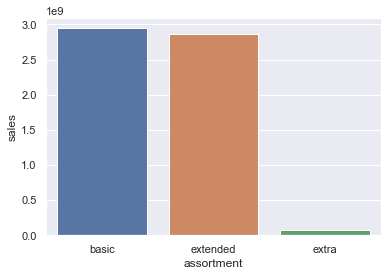

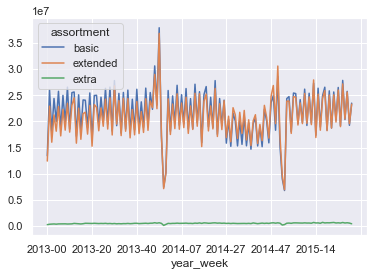

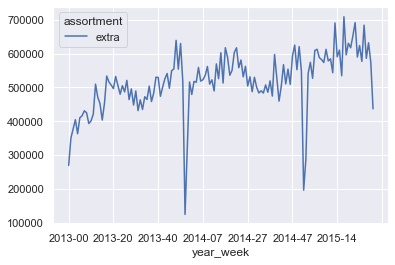

In [39]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.plot()

aux4 = aux2[ aux2['assortment'] == 'extra' ]
aux5 = aux4.pivot( index='year_week', columns='assortment', values='sales' )
aux5.plot()

In [40]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [41]:
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


### **H2.** Lojas com competidores mais próximos deveriam vender menos.( senso comum )
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.<p>
**É importante pro modelo?** pode ser importante para o modelo, mas de uma forma mais fraca

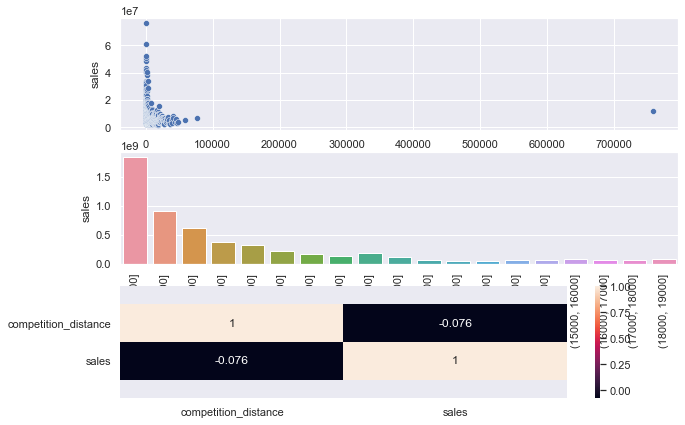

In [42]:
plt.figure( figsize=( 10, 7 ) )
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 3, 1, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 3, 1, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 3, 1, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );# ver a correlaçao das distancias e das vendas
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [43]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
169,1930.0,5751886,"(1000, 2000]"
493,10740.0,7318373,"(10000, 11000]"
121,1340.0,12120341,"(1000, 2000]"
58,600.0,6980916,"(0, 1000]"


### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**Falsa** Lojas com competidores a mais tempo vendem menos, bem contraintuitivo

**É importante para o modelo?** pode ser, mas nem tanto, pearson fraco

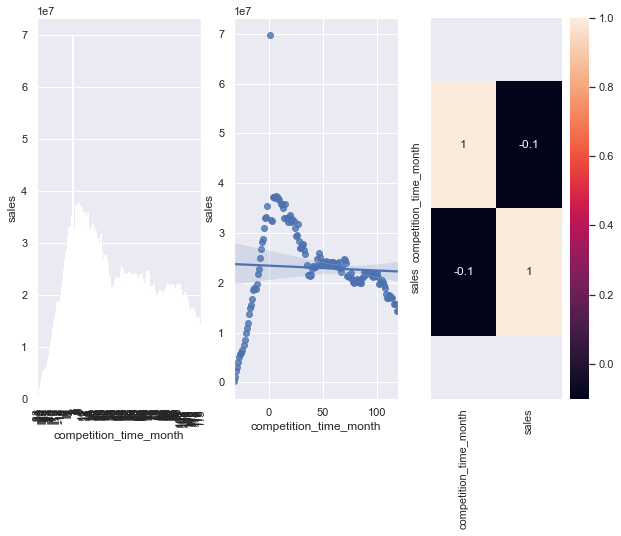

In [44]:
plt.figure( figsize=( 10, 7 ) )
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

In [45]:
df4.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H4 .Lojas com maior sortimentos deveriam vender mais.
**False** pois lojas com promoçoes ativas por amis tempos vendem menos, edpois de um certo periodo de promoçao 

**É importante para o modelo?** Nao, pearson baixo

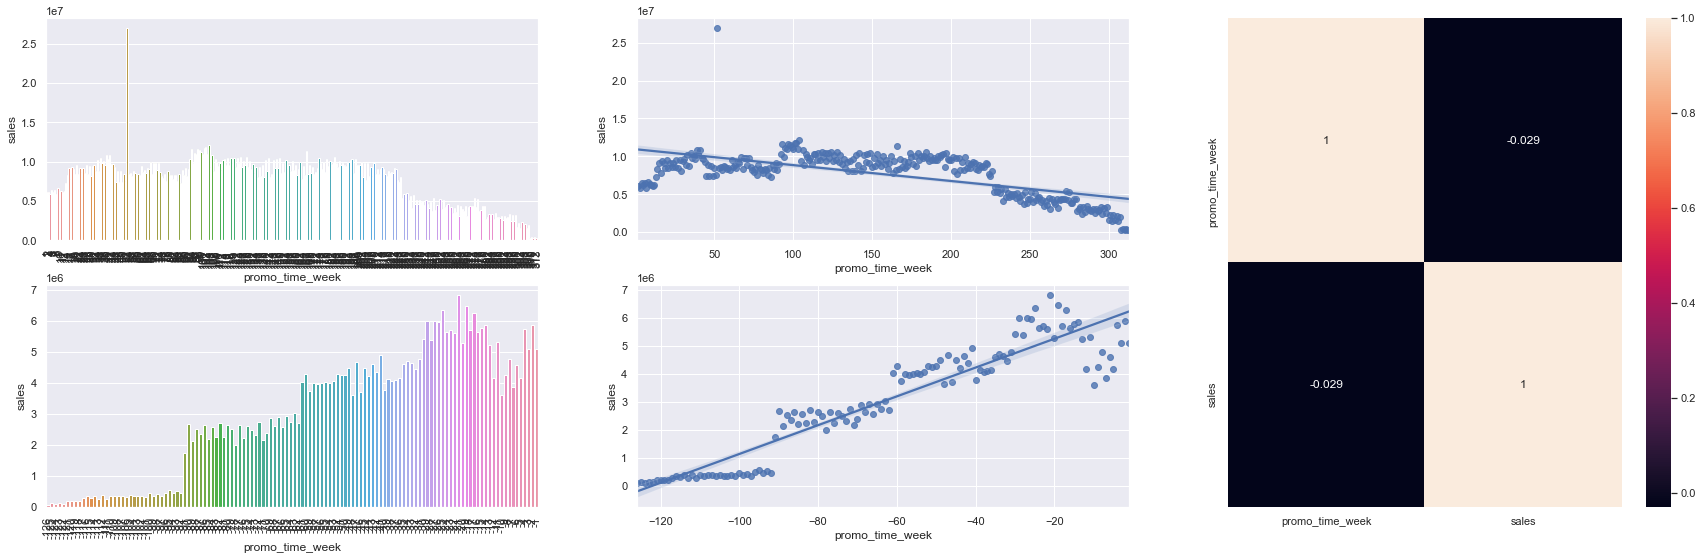

In [46]:
# granularidade -> ex: venda por dia por loja, menor porçao dos dados
plt.figure( figsize=( 30, 9 ) )

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5. Lojas com mais dias de promoçao deveriam vender mais</s>

In [47]:
# Cara essa h5 é bem parecida com h4, 
# entao vamos deixar para o segundo ciclo do CRISP-DaS

### H7.Lojas com mais promoçoes consecutivas deveriam vender mais
- Nao é tao relevante essa hipotese para o modelo, pois é mt pouco a diferença da tradicional e extenida para a so extendida, e o comportamento estranho que poderia ser analisado pelo modelo é mt pequeno entao nem deve influenciar, depois pegamos opiniao de um algoritmo

**Falsa** Lojas com mais promoçoes consecutivas vendem menos

**É importante para o modelo?** Deve sim, tem um fenomeno que do nada cai o modo tradicional, que pode ser importante para o modelo aprender

In [48]:
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


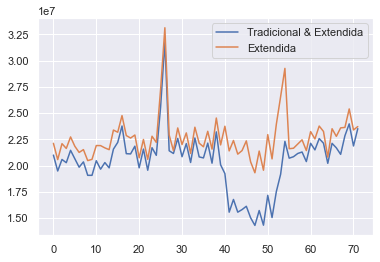

In [49]:

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de natal vendem menos

- Ja é algo conhecido, nao é um insight

**É importante para o modelo?** Sim, pois se for feriado muda como que o modelo tem que prever

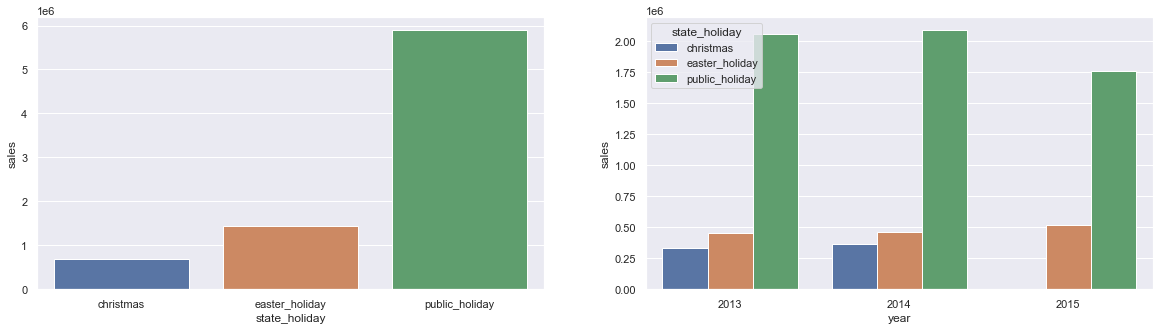

In [50]:
plt.figure( figsize=( 20, 5 ) )
plt.subplot( 1,2,1 )
aux = df4[ df4['state_holiday'] != 'regular_day' ]
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1,2,2 )
aux2 = aux[['year','state_holiday', 'sales' ]].groupby( [ 'year', 'state_holiday' ] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**False** Lojas vendem menos ao longo dos anos

- No é insight, pois as pessoas ja devem saber
- Sempre comparar entre periodos fechados, posi senao vai da um problema na sua naalise, ja qeu nao tem todos os daddos daquele periodo

**É importante para o modelo?** Sim, altissima correlaçao

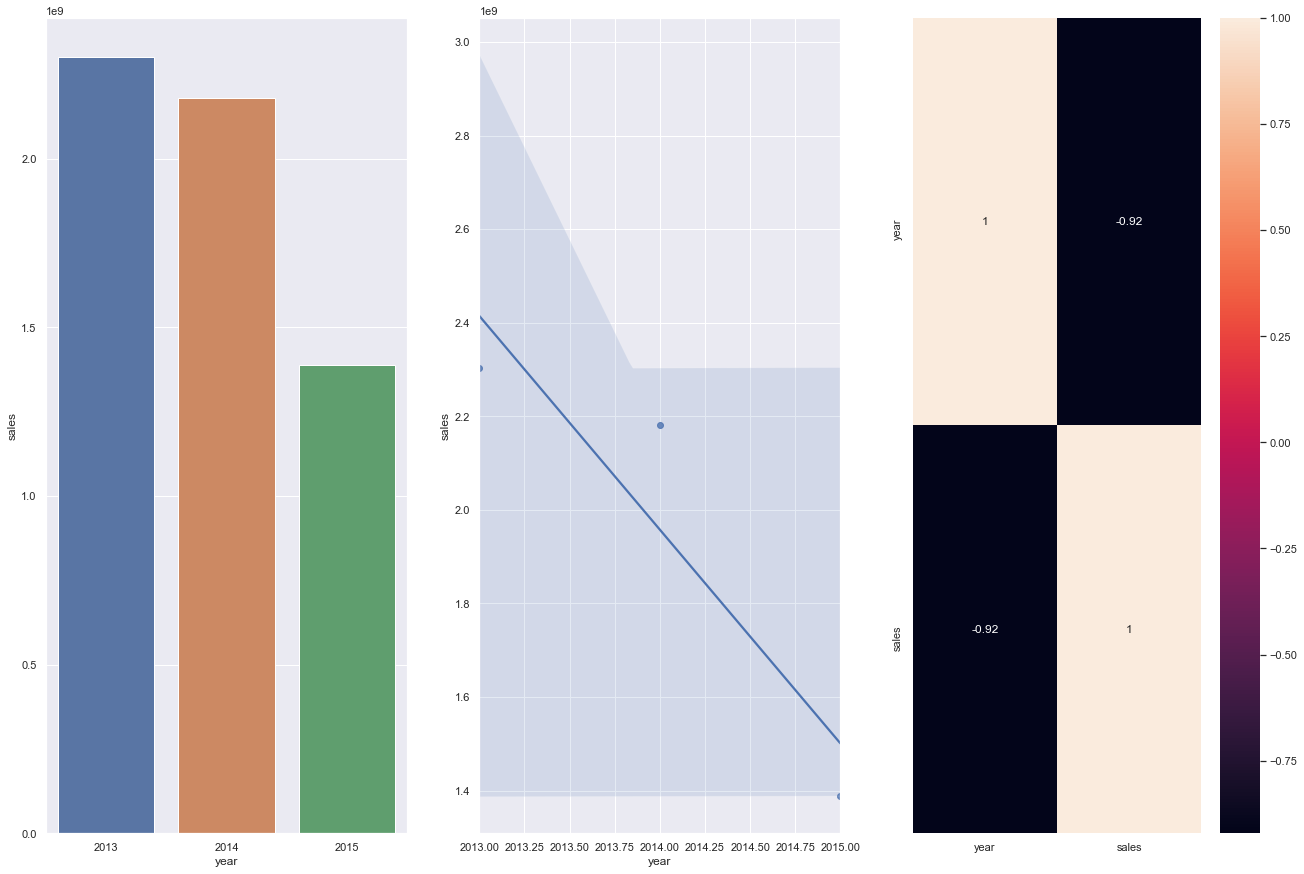

In [51]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.

- Nao é um insight, as pessoas ja devem saber disso, nao é nem contraintutitivo nem uma informaçao nova


**É importante para o modelo?**Sim, correlaçao alta

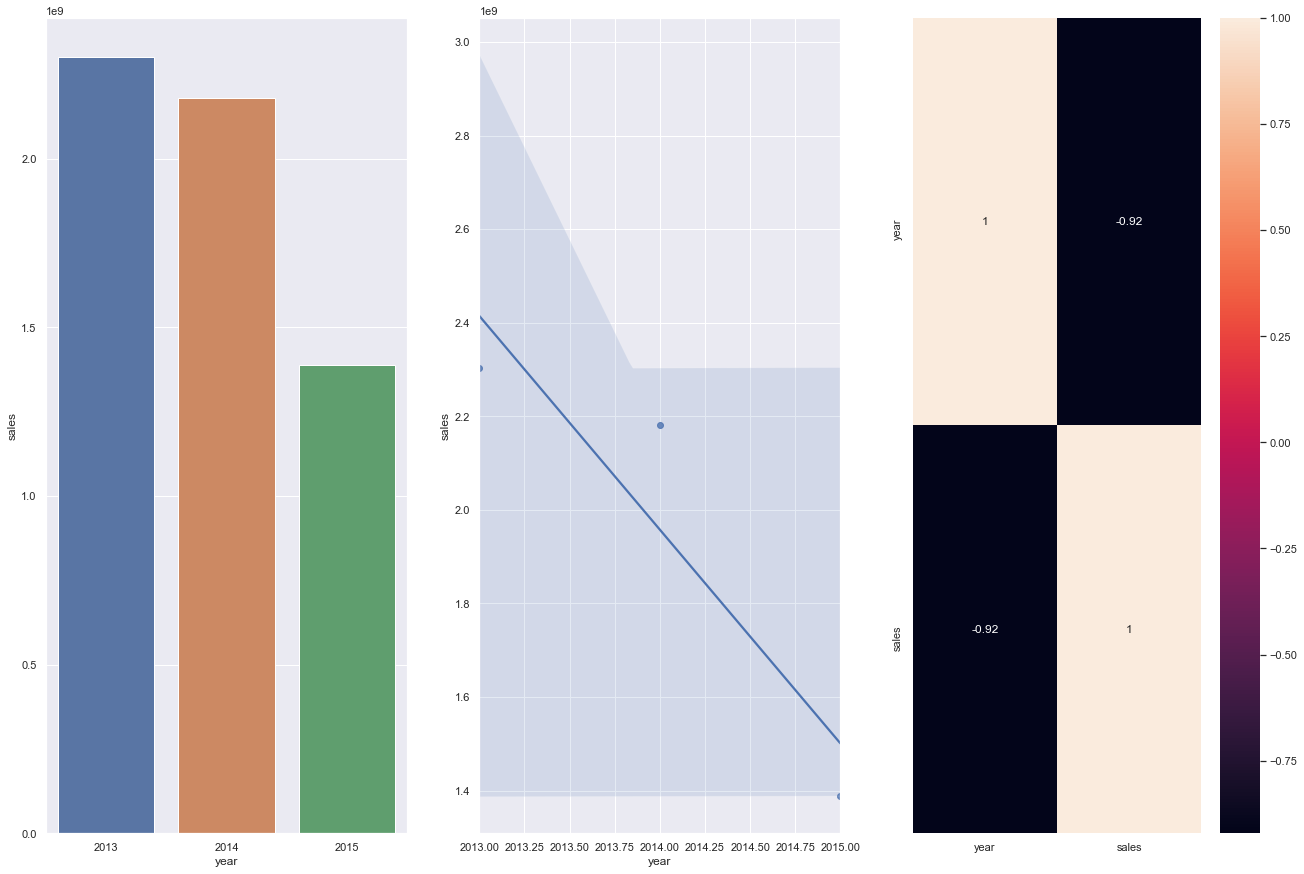

In [52]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** Lojas vendem mais depois do dia 10 de cada mes

- Nao é insight, pois pessoas acompanham isso ja

**É importante para o modelo?** Sim, pois tem uma certa correlaçao negativa( quanto maior um, menor outro )

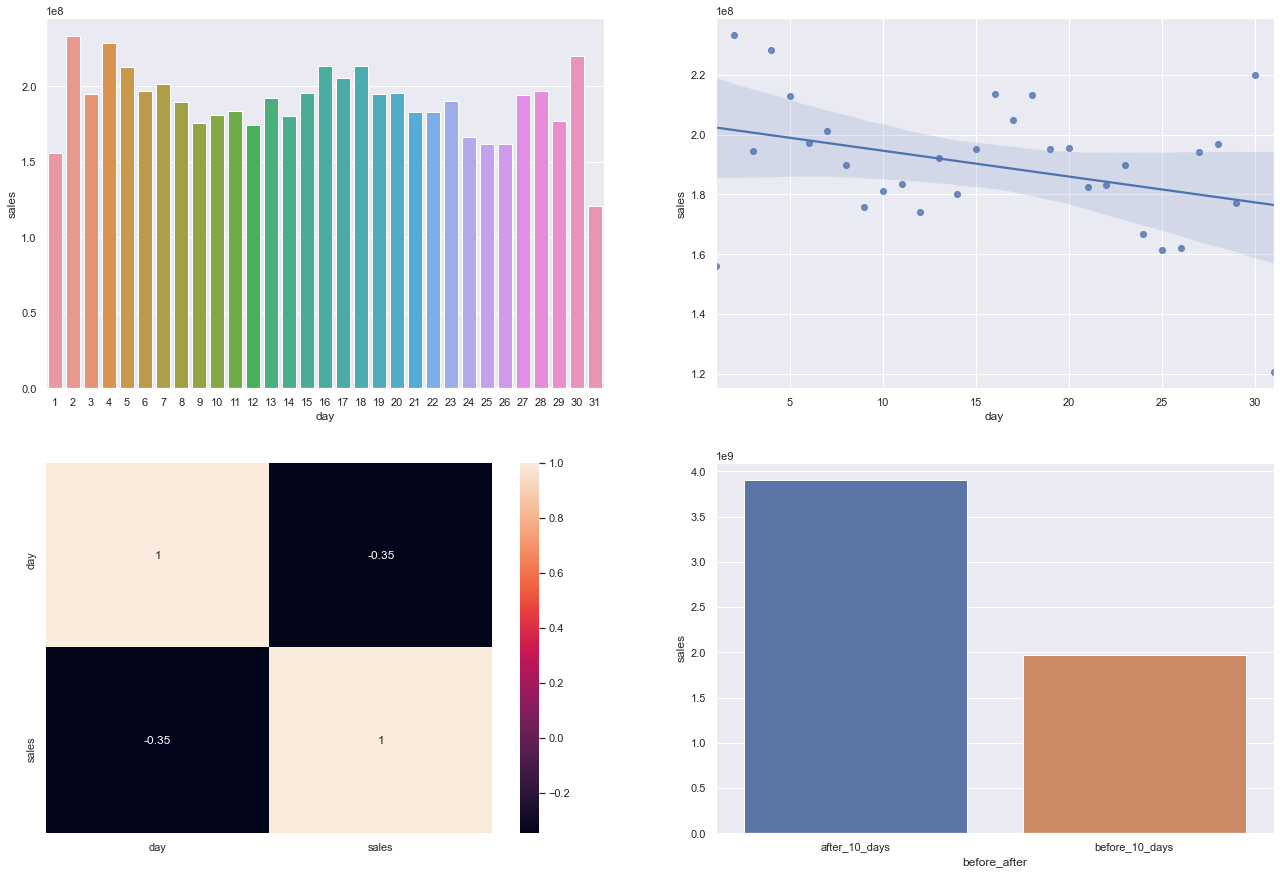

In [53]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2,2,1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x<=10 else 'after_10_days' )

plt.subplot( 2,2,4 )
aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );


### **H12.** Lojas deveriam vender menos aos finais de semana.
**Verdadeira** Lojas vendem menos nos finais de semana

**É importante para o modelo?** Sim, correlaçao alta

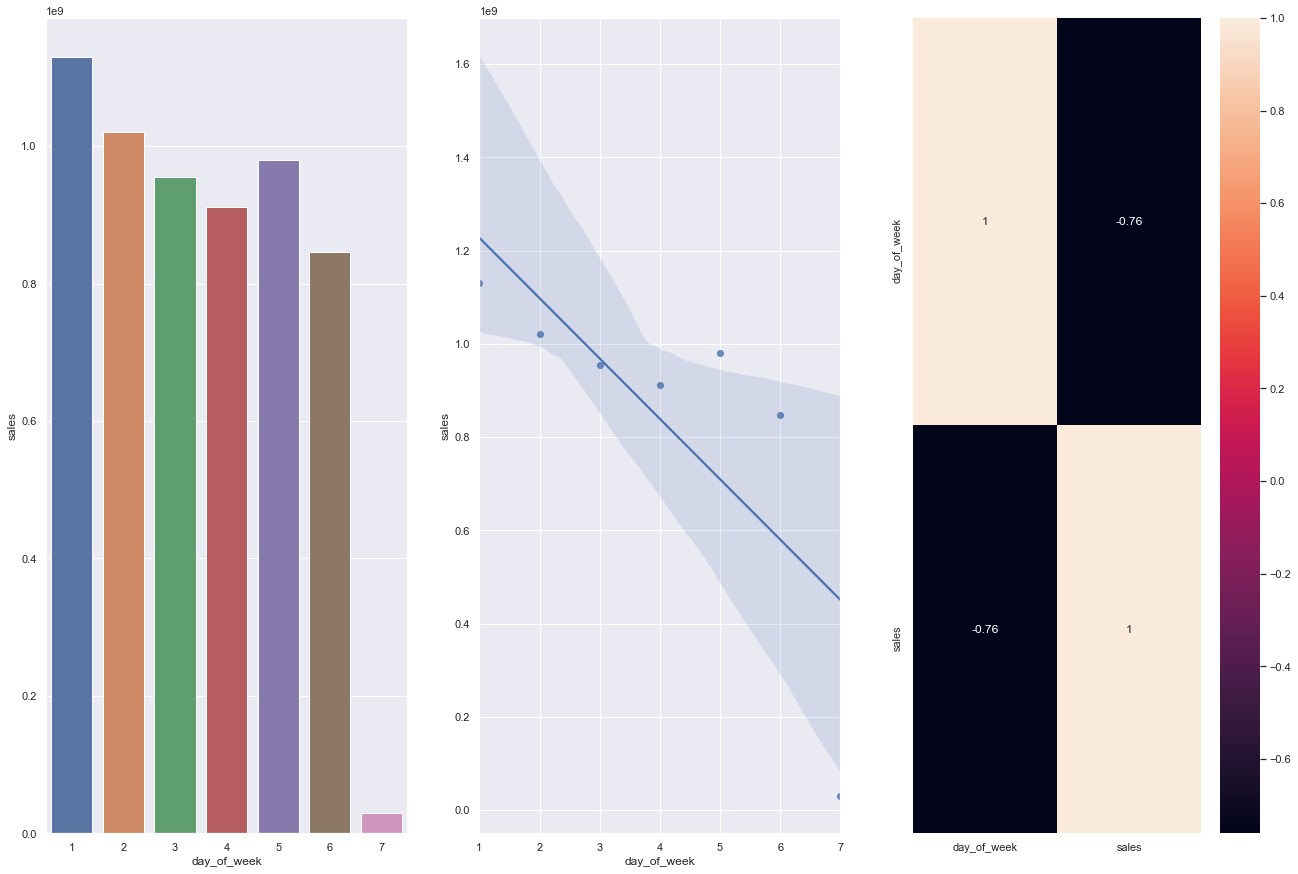

In [54]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durante os feriados escolares, except os meses de Julho e Agosto

- Noa deve ser insight, o time de negoicos ja deve saber disso

**É importante para o modelo?** Sim, para modelar o algoritmo precisa saber se é feriado escolar, e que mes esta

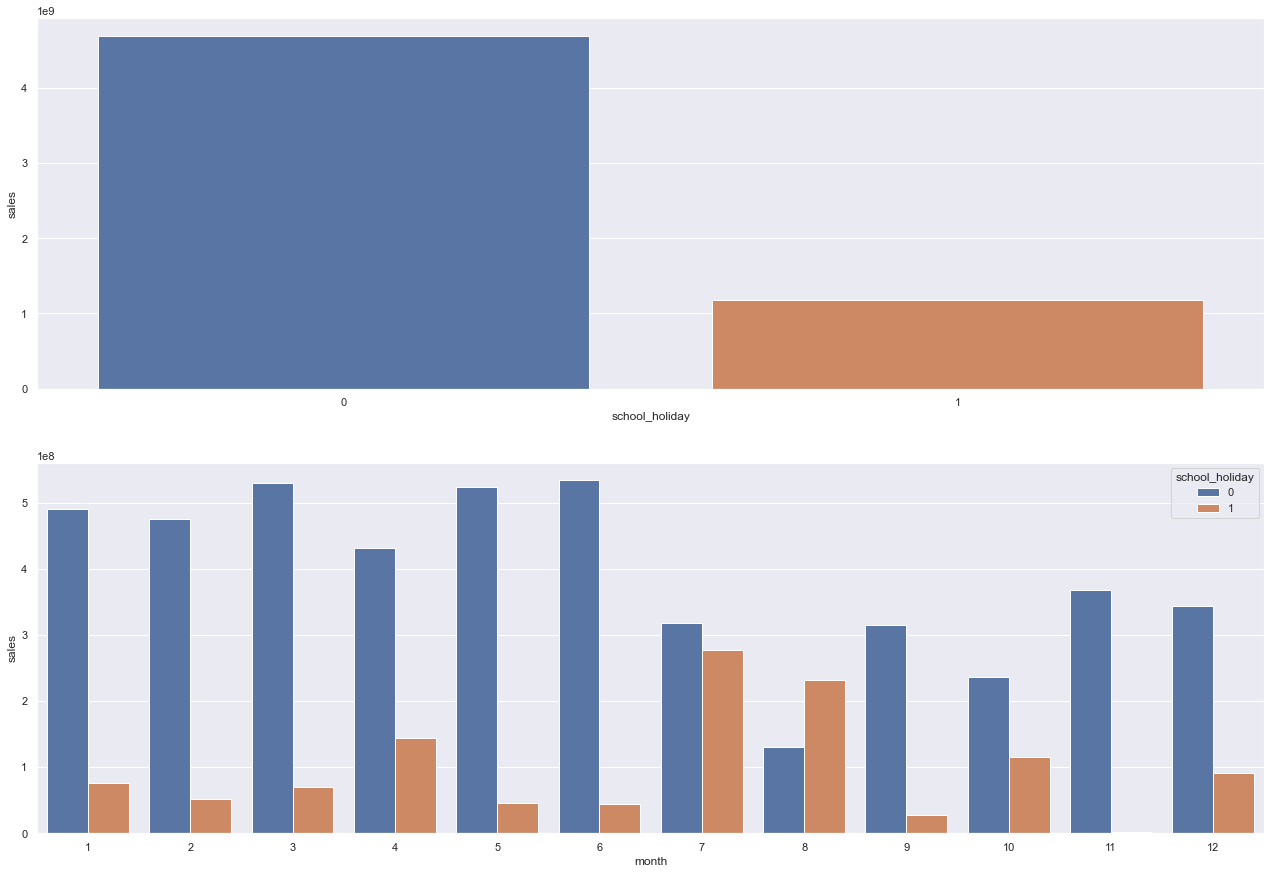

In [55]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2,1,1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month','school_holiday', 'sales']].groupby([ 'month','school_holiday' ]).sum().reset_index()

plt.subplot( 2,1,2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


## 4.2.1 Resumo das hipoteses

In [56]:
# from tabulate import tabulate

In [57]:

# tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
#       ['H1', 'Falsa', 'Baixa'],  
#       ['H2', 'Falsa', 'Media'],  
#       ['H3', 'Falsa', 'Media'],
#       ['H4', 'Falsa', 'Baixa'],
#       ['H5', '-', '-'],
#       ['H7', 'Falsa', 'Baixa'],
#       ['H8', 'Falsa', 'Media'],
#       ['H9', 'Falsa', 'Alta'],
#       ['H10', 'Falsa', 'Alta'],
#       ['H11', 'Verdadeira', 'Alta'],
#       ['H12', 'Verdadeira', 'Alta'],
#       ['H13', 'Verdadeira', 'Baixa'],
#      ]  
# print( tabulate( tab, headers='firstrow' ) )


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

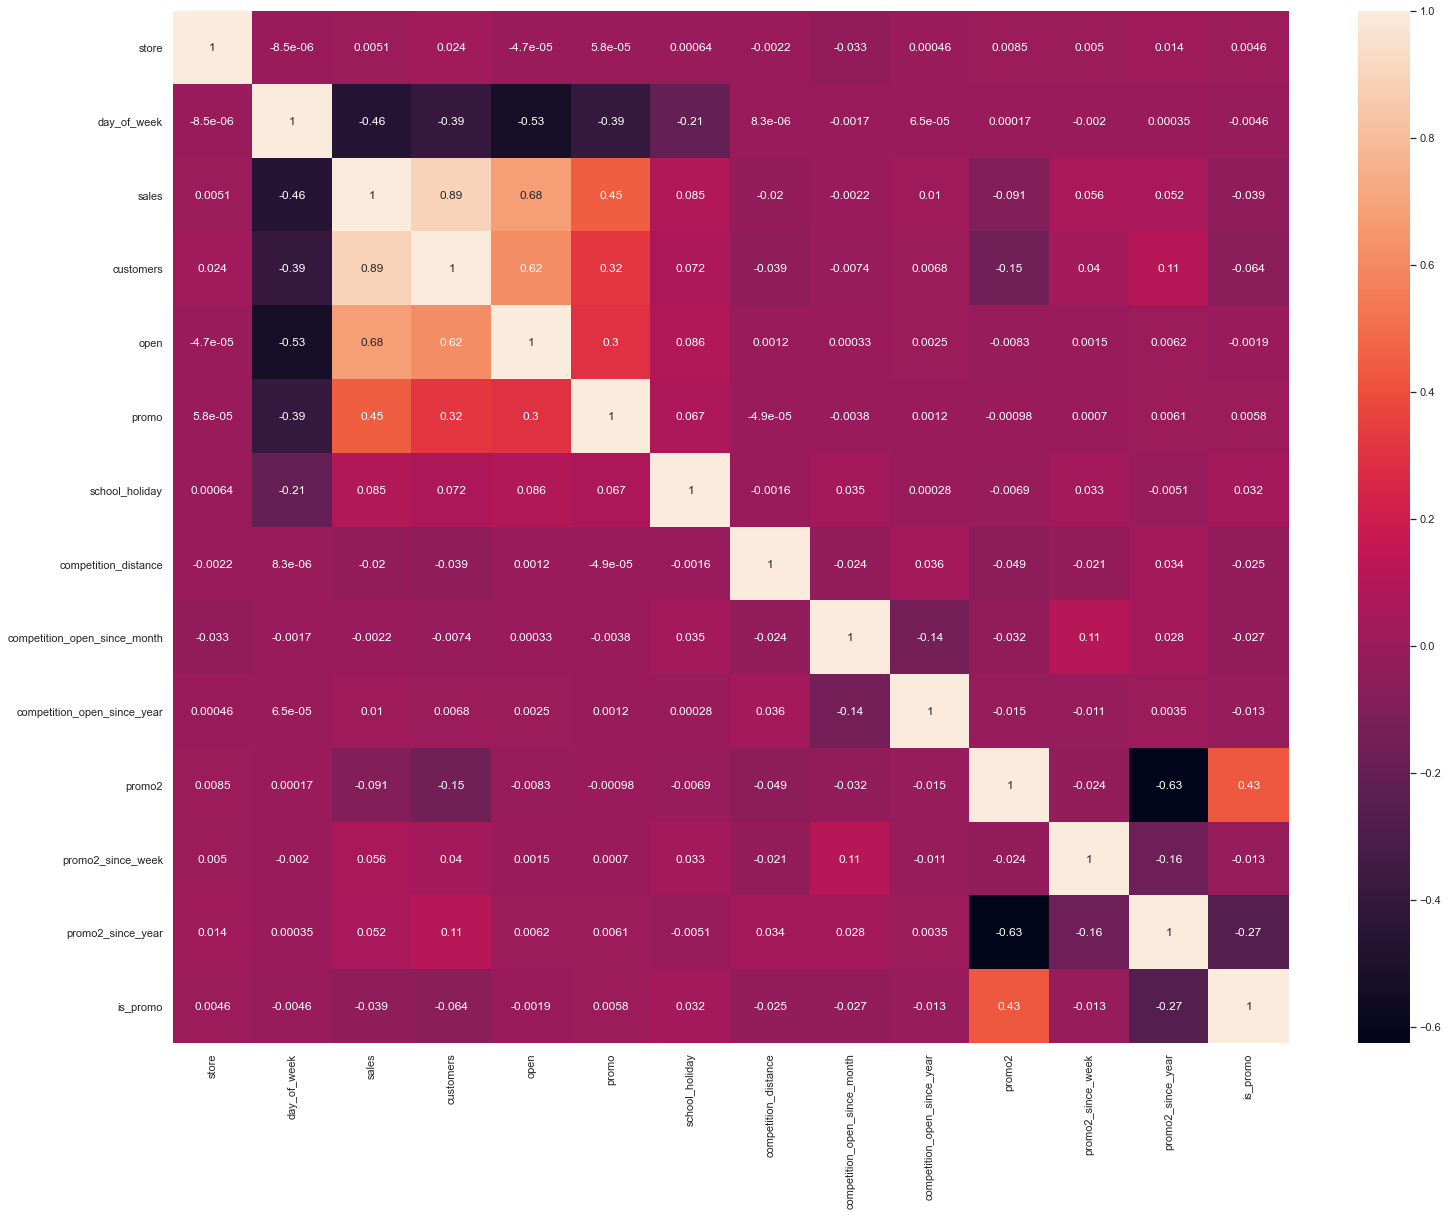

In [58]:
correlation = num_attributes.corr( method='pearson' )
plt.figure( figsize=( 25, 19 ) )
sns.heatmap( correlation, annot=True );

# Temos um problema aqui, temos por exemplo uma correlaçao alta de costumers
# com sales, mas n podemos faer nada, pois nao temos como prever quantos
# costumers vao ter nas poroximas 6 semanas, so se fizessemos um projeto separadoe depois
# Incorporasse aqui nesse projeto, Porblema supçer comum

### 4.3.2 Categorical Attributes

In [59]:
a = df4.select_dtypes( include='object' )

In [60]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [61]:
cm = pd.crosstab( a['state_holiday'], a['store_type'] )
cm = cm.values

In [62]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
                   'store': [a4,a5,a6],
                   'assortment': [a7,a8,a9],    
                    })
d = d.set_index( d.columns )


In [63]:
d

,state_holiday,store,assortment
state_holiday,1.000002,0.071065,0.067546
store,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

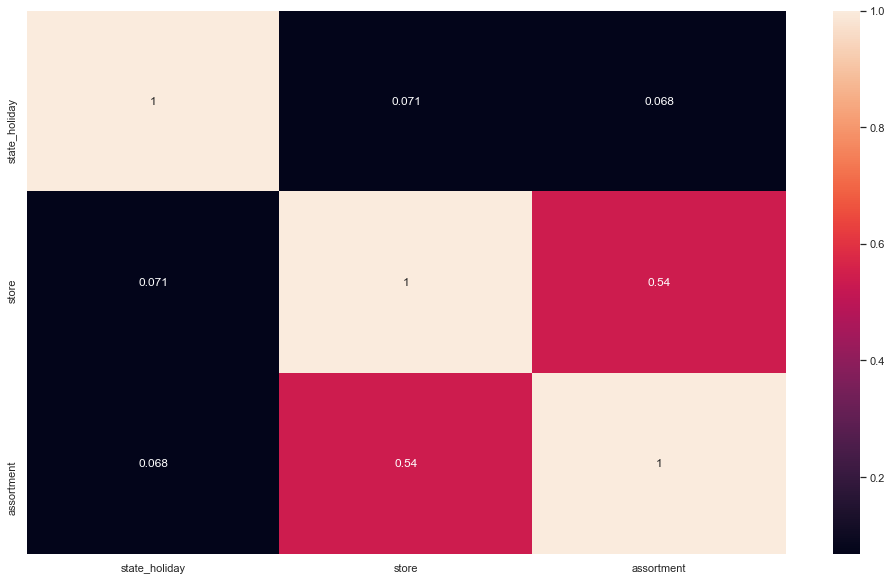

In [64]:
plt.figure( figsize=( 17, 10 ) )
sns.heatmap( d, annot=True ) # ver a correlaçao das variaveis categoricas


# 5.0 Data Preparation

In [65]:
df5 = df4.copy()

## 5.1 Normalizaçao

In [66]:
# Nao é necessario fazer, pois nenhuma variavel categorica
# tem uma distribuiçao que pareça normal por ela porpria

## 5.2 Rescaling

In [80]:
a = df5.select_dtypes( include=['int64', 'float64','int32','UInt32'] )

C:\Users\PICHAU\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

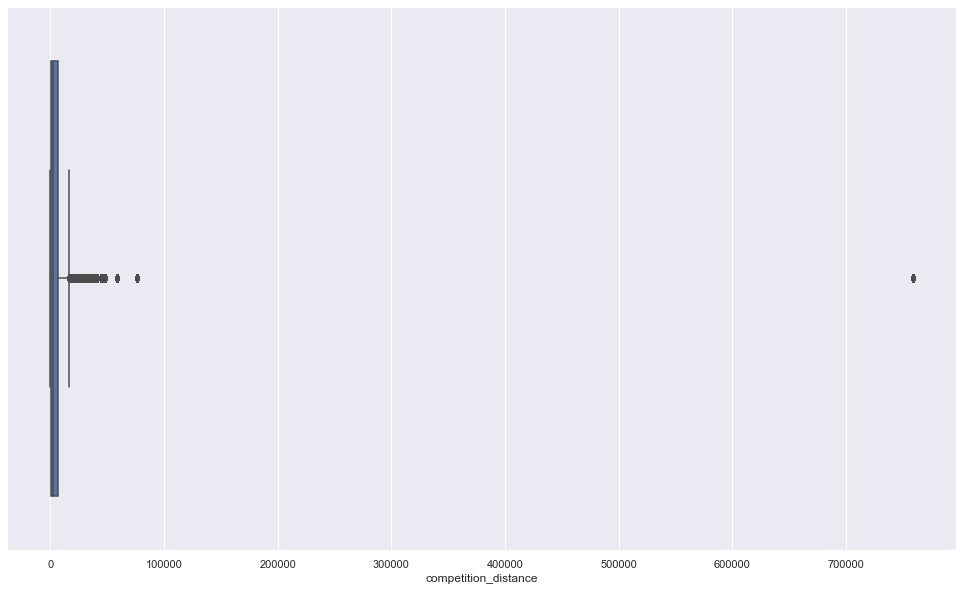

In [83]:
plt.figure( figsize=( 17, 10 ) )
sns.boxplot( df5['competition_distance'] )

In [89]:
rs =  RobustScaler()
mms = MinMaxScaler()

# competititon distance( robust scaler, pois tem outliers mt grandes )  
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values ) # ja encontra os quartis e faz o calculo pra gente da coluna

# year( min-max, nao tem outliers tao fortes )
df5['year'] = mms.fit_transform( df5[['year']].values )

# competition time month( robust scaler, pois tem outliers mt grandes )
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week( min-max, pois nao tem outliers tao fortes )
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# separados so os que nao tem natureza ciclica

C:\Users\PICHAU\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


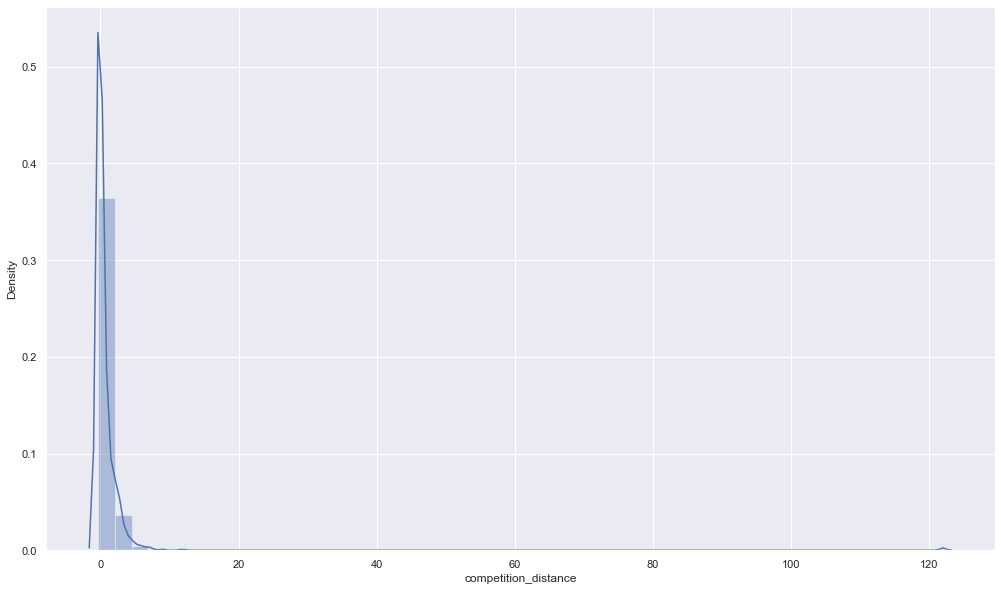

In [92]:
plt.figure( figsize=( 17, 10 ) )
sns.distplot( df5['competition_distance'] );

## 5.3 Transformaçao

In [ ]:
# month
# day
# Week of year
# day of week